<a href="https://colab.research.google.com/github/yohanesnuwara/reservoir-engineering/blob/master/Unit%204%20Volumetrics/notebook/4_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Unit 4 Volumetrics (Examples)**


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
!git clone https://www.github.com/yohanesnuwara/reservoir-engineering

Cloning into 'reservoir-engineering'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 264 (delta 41), reused 0 (delta 0), pack-reused 158
Receiving objects: 100% (264/264), 239.36 KiB | 14.08 MiB/s, done.
Resolving deltas: 100% (108/108), done.


# Problem 4.1 Determination of OIP by Volumetrics

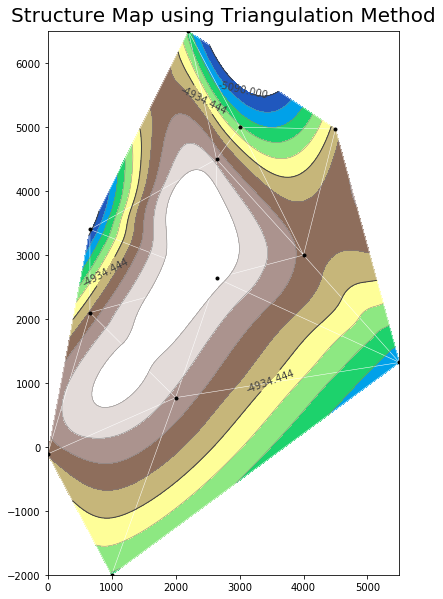

In [3]:
"Task 1. Plot contour map"

# Tricontour (triangulation) method"

import matplotlib.tri as tri
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import math
from scipy.interpolate import griddata

# data

welldat = pd.read_csv('/content/reservoir-engineering/Unit 4 Volumetrics/data/Table 4.1-Well Data for Example 4.1.csv')
x, y, depth = welldat.x, welldat.y, welldat.depth
z = depth

# Now create the Triangulation.
# (Creating a Triangulation without specifying the triangles results in the
# Delaunay triangulation of the points.)
triang = tri.Triangulation(x, y)

#-----------------------------------------------------------------------------
# Refine data
#-----------------------------------------------------------------------------
refiner = tri.UniformTriRefiner(triang)
tri_refi, z_test_refi = refiner.refine_field(z, subdiv=5)

#-----------------------------------------------------------------------------
# Plot the triangulation and the high-res iso-contours
#-----------------------------------------------------------------------------
plt.figure(figsize=(20, 10))
plt.gca().set_aspect('equal')
plt.triplot(triang, lw=0.5, color='white')

levels = np.linspace(min(z)+10, max(z)-10, 10)  ##contour range, divided by 10 levels
cmap = cm.get_cmap(name='terrain', lut=None)
fig = plt.tricontourf(tri_refi, z_test_refi, levels=levels, cmap=cmap)
fig = plt.tricontour(tri_refi, z_test_refi, levels=levels,
               colors=['0.25', '0.5', '0.5', '0.5', '0.5'],
               linewidths=[1.0, 0.5, 0.5, 0.5, 0.5])
plt.plot(x, y, 'ko', ms=3) # plot the well points
plt.clabel(fig, fig.levels[::5], inline=1, fontsize=10) # give labels for contours, fig.levels[::x] controls the frequency of labels
                                                        # lesser ::x, more populated by labels
plt.title("Structure Map using Triangulation Method", pad=10, size=20)

plt.show()

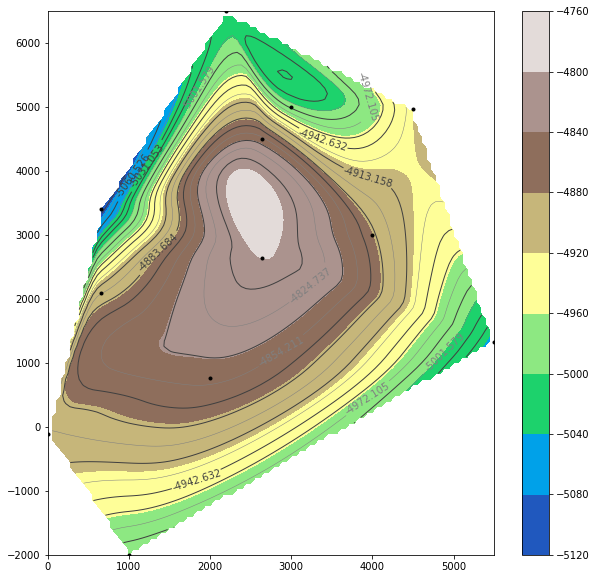

In [4]:
# Python contourf method

import scipy
from scipy.interpolate import griddata

xi = np.linspace(min(x), max(x), 100)
yi = np.linspace(min(y), max(y), 100)
xi, yi = np.meshgrid(xi, yi)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

cmap = cm.get_cmap(name='terrain', lut=None)

# levels = np.arange(-5500, -4500, 10)  ##contour range
# levels = np.linspace(-5000, -4800, 20)  ##contour range

levels = np.linspace(min(z)+10, max(z)-10, 20)  ##contour range, divided by 20 levels

plt.figure(figsize=(10, 10))
figs = plt.contour(xi, yi, zi, levels=levels, colors=['0.25', '0.5', '0.25', '0.5', '0.25'], linewidths=[1.0, 0.5, 1, 0.5, 1])
plt.contourf(xi,yi,zi, cmap="terrain")
plt.plot(x, y, 'ko', ms=3) # plot the well points
plt.clabel(figs, figs.levels[::2], inline=1, fontsize=10) # give labels for contours, fig.levels[::x] controls the frequency of labels
                                                        # lesser ::x, more populated by labels
plt.colorbar()
plt.show()

In [5]:
# Use Green's theorem to compute the area
# enclosed by the given contour.
def area(vs):
    a = 0
    x0,y0 = vs[0]
    for [x1,y1] in vs[1:]:
        dx = x1-x0
        dy = y1-y0
        a += 0.5*(y0*dx - x0*dy)
        x0 = x1
        y0 = y1
    return a

# levels = np.linspace(-5000, -4800, 20)
levels = np.linspace(min(z)+10, max(z)-10, 10)  ##contour range
# levels = np.arange(min(z), max(z), 10)  ##contour range

# Get one of the contours from the plot.

a_array = []

for i in range(len(levels)):
    contour = figs.collections[i]
    vs = contour.get_paths()[0].vertices
    # Compute area enclosed by vertices.
    a = area(vs)
    a_array.append(float(np.abs(a)))
    # print("r = " + str(levels[i]) + ": a =" + str(a))

areas = pd.DataFrame({"Depth Contour (ft)": levels, "Area (ft2)": a_array})
areas

,Depth Contour (ft),Area (ft2)
0,-5090.000000,1.587652e+05
1,-5058.888889,4.489755e+05
2,-5027.777778,6.553545e+04
3,-4996.666667,6.383565e+05
4,-4965.555556,1.069707e+06
5,-4934.444444,2.011804e+06
6,-4903.333333,5.473737e+05
7,-4872.222222,5.948592e+05
8,-4841.111111,3.536188e+06
9,-4810.000000,7.788241e+06


In [6]:
"Task 2. Compute N for each well data"

# known

Bo = 1.435 # in RB/STB
owc = -4960 # oil water contact, in ft

# N = h*poro*(1-Sw) / Bo, in unit ft3/ft2

N = welldat.h * welldat.poro * (1 - welldat.sw) / Bo
N = N * (1 / 5.61458) # convert the result from ft3/ft2 to standard STB/ft2
Ndf = pd.DataFrame({"well_id": welldat.well_id, "N (STB/ft2)": N})
Ndff = pd.merge(welldat, Ndf, on='well_id')
Ndff

,well_id,x,y,depth,h,poro,sw,N (STB/ft2)
0,1,0.0,-110.0,-4900,25,0.200,0.50,0.310292
1,2,4500.0,4970.0,-4920,33,0.205,0.65,0.293878
2,3,2640.0,2640.0,-4800,44,0.200,0.20,0.873783
3,4,660.0,2100.0,-4900,36,0.190,0.22,0.662188
4,5,2000.0,770.0,-4850,22,0.023,0.27,0.045846
5,6,2640.0,4500.0,-4850,45,0.242,0.23,1.040757
6,7,4000.0,3000.0,-4880,23,0.235,0.22,0.523264
7,8,660.0,3400.0,-5100,34,0.230,1.00,0.000000
8,9,5500.0,1320.0,-5050,24,0.190,1.00,0.000000
9,10,2200.0,6500.0,-5010,11,0.210,1.00,0.000000


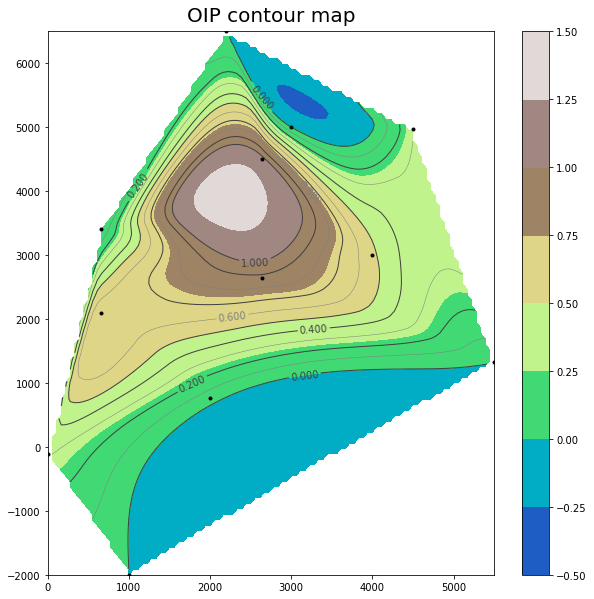

In [7]:
"Task 3. plot contour map of OIP from the resulted N data"

import scipy
from scipy.interpolate import griddata

z = N # z is now the N data

xi = np.linspace(min(x), max(x), 100)
yi = np.linspace(min(y), max(y), 100)
xi, yi = np.meshgrid(xi, yi)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

cmap = cm.get_cmap(name='terrain', lut=None)

# levels2 = np.linspace(min(z), max(z), 10)  ##contour range, divided by 10 levels
levels2 = np.arange(0, max(z), 0.1)

plt.figure(figsize=(10, 10))
figs = plt.contour(xi, yi, zi, levels=levels2, colors=['0.25', '0.5', '0.25', '0.5', '0.25'], linewidths=[1.0, 0.5, 1, 0.5, 1])
plt.contourf(xi,yi,zi, cmap="terrain")
plt.plot(x, y, 'ko', ms=3) # plot the well points
plt.clabel(figs, figs.levels[::2], inline=1, fontsize=10) # give labels for contours, fig.levels[::x] controls the frequency of labels
                                                        # lesser ::x, more populated by labels
plt.title("OIP contour map", pad=10, size=20)
plt.colorbar()
plt.show()

In [85]:
"Task 5. calculate area of N contours"

# Use Green's theorem to compute the area
# enclosed by the given contour.
def area(vs):
    a = 0
    x0,y0 = vs[0]
    for [x1,y1] in vs[1:]:
        dx = x1-x0
        dy = y1-y0
        a += 0.5*(y0*dx - x0*dy)
        x0 = x1
        y0 = y1
    return a

# levels = np.linspace(min(z)+10, max(z)-10, 10)  ##contour range

# Get one of the contours from the plot.

a_array = []

for i in range(len(levels2)):
    contour = figs.collections[i]
    vs = contour.get_paths()[0].vertices
    # Compute area enclosed by vertices.
    a = area(vs)
    a_array.append(float(np.abs(a)))
    # print("r = " + str(levels[i]) + ": a =" + str(a))

areas = pd.DataFrame({"OIP Contour(STB)": levels2, "Area(ft2)": a_array})
areas

,OIP Contour(STB),Area(ft2)
0,0.0,1.581738e+06
1,0.1,5.164481e+04
2,0.2,3.970719e+05
3,0.3,3.465943e+04
4,0.4,8.217191e+05
5,0.5,9.068078e+06
6,0.6,7.543685e+06
7,0.7,5.017789e+06
8,0.8,2.501886e+06
9,0.9,2.801986e+06


**Task 4. Calculate total OIP**

**Method 1. Trapezoidal Rule**

In [86]:
"Task 4. calculate total OIP"

# Method 1. Trapezoidal rule

# simplification: V = delta_z/2*(a1+an) + delta_z/2(2*a2+2*a3+2*an-1) as V = first_term + second_term

delta_z = 0.1
first_term = 0.5 * delta_z * (a_array[0] + a_array[-1]) # a_n (last area) is a_array[-1] in python

# delete a0 and an
a_array_trapez = np.delete(a_array, 0)
a_array_trapez = np.delete(a_array_trapez, -1)

second_term = np.sum(2 * a_array_trapez)
second_term = 0.5 * delta_z * second_term
oip_trapez = first_term + second_term
print("Oil in Place using Trapezoidal Method:", oip_trapez / 1E+06, "million STB")

Oil in Place using Trapezoidal Method: 3.0323398371920924 million STB


In [81]:
def trapezoid(y_vals, h):

  # simplification: V = h/2*(a1+an) + h/2(2*a2+2*a3+2*an-1) as V = first_term + second_term
  first_term = 0.5 * h * (y_vals[0] + y_vals[-1])

  # delete a0 and an
  y_trapez = np.delete(y_vals, 0)
  y_trapez = np.delete(y_trapez, -1)

  second_term = np.sum(2 * y_trapez)
  second_term = 0.5 * h * second_term
  return first_term + second_term

oip_trapezo = trapezoid(a_array, 0.1)
print("Oil in Place using Trapezoidal Method:", oip_trapezo / 1E+06, "million STB")

Oil in Place using Trapezoidal Method: 3.0323398371920924 million STB


**Method 2. 1/3 Simpson Rule**

In [79]:
def simpson(y_vals, h):
    i = 1
    total = y_vals[0] + y_vals[-1]
    for y in y_vals[1:-1]:
        if i % 2 == 0:
            total += 2 * y
        else:
            total += 4 * y
        i += 1
    return total * (h / 3.0)

oip_simpson = simpson(a_array, 0.1)
print("Oil in Place using 1/3 Simpson's Method:", oip_simpson / 1E+06, "million STB")

Oil in Place using 1/3 Simpson's Method: 3.1531703422977366 million STB


**Method 3. Pyramidal Rule**

In [89]:
# do the same, sort out a_0 and a_n, calculate the first term, 1/3*delta_z*(a_0+a_n)

minus_a0 = np.delete(a_array, 0)
minus_a0_an = np.delete(minus_a0, -1)
first_term = a_array[0] + a_array[-1]

# multiply the the first part of second term from sorted list: second_term_1 = (delta_z/3) * (2a1+2a2+...+2an-1)

second_term_1 = 2 * (np.sum(minus_a0_an))

# process the second part of second term from sorted list: second_term_2 = (delta_z/3) * (sqrt(a1*a2)+sqrt(a2*a3)+...+sqrt(an-2*an-1))

second_term_2 = [np.sqrt(j*i) for i, j in zip(a_array[:-1], a_array[1:])]
second_term_2 = np.sum(second_term_2)

# oip_pyramid = first_term + second_term_1 + second_term_2

oip_pyramid = (delta_z / 3) * (first_term + second_term_1 + second_term_2)
print("Oil in Place using Pyramidal Rule:", oip_pyramid / 1E+06, "million STB")

Oil in Place using Pyramidal Rule: 2.913287196707699 million STB


In [95]:
def pyramid(y_vals, h):
  import numpy as np
  # sort out a_0 and a_n, calculate the first term, 1/3*delta_z*(a_0+a_n)

  minus_a0 = np.delete(y_vals, 0)
  minus_a0_an = np.delete(minus_a0, -1)
  first_term = y_vals[0] + y_vals[-1]

  # multiply the the first part of second term from sorted list: second_term_1 = (delta_z/3) * (2a1+2a2+...+2an-1)

  second_term_1 = 2 * (np.sum(minus_a0_an))

  # process the second part of second term from sorted list: second_term_2 = (delta_z/3) * (sqrt(a1*a2)+sqrt(a2*a3)+...+sqrt(an-2*an-1))

  second_term_2 = [np.sqrt(j*i) for i, j in zip(y_vals[:-1], y_vals[1:])]
  second_term_2 = np.sum(second_term_2)

  # oip_pyramid = first_term + second_term_1 + second_term_2

  return (h / 3) * (first_term + second_term_1 + second_term_2)

oip_pyramida = pyramid(a_array, 0.1)
print("Oil in Place using Pyramidal Rule:", oip_pyramida / 1E+06, "million STB")

Oil in Place using Pyramidal Rule: 2.913287196707699 million STB
